# Predicting Song Popularity with Spotify API Tutorial 

**By Thomas Szymkiewicz and John Wright **
 
With most albums, there’s usually two or three main hits, and there’s usually two or three songs that get overlooked. In general, people tend to gravitate towards to the same songs. For example, energetic and catchy songs often get more plays than slow songs. Computers obviously can’t decide if a song is good or bad, but in this project, we want to see if we can train an algorithm to recognize hit potential. We will be looking at specific albums and seeing if our algorithm can accurately sort the hits from the duds.

The purpose of this tutorial is to predict the most popular song within an album from song features, including acousticness, duration, danceability, instrumentalness, and other features, collected from the track’s Spotify API features and show the user how to replicate this. The Spotify API features collected in this tutorial are listed here under "Responses": https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features 

 
 

Our goal is to successfully predict the most played song on Spotify in an artist’s album through the use of a Random Forest algorithm trained on Spotify track data and to successfully demonstrate to a reader how to replicate this process. Training data was collected from a Kaggle dataset https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre. The dataset was downloaded locally and then uploaded into our program and read using the Pandas read_csv() function. After training, test data will be separated by various artists’ albums. Because some artists are far more recognized and popular than other artists, separating analysis by album  in the test data will prevent the algorithm from skewing track popularity based on artist recognition. Instead we are basing our algorithm solely on the music features. 

In [2]:
import pandas as pd
import numpy as np
from google.colab import files
import io

uploaded = files.upload()
full_dataset = pd.read_csv(io.BytesIO(uploaded['music_genre.csv']))

Saving music_genre.csv to music_genre.csv


#Data Scraping, Curation, and Parsing 

 
 

The training data was collected from the Kaggle dataset "Prediction of music genre" https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre which classifies a track into one of ten genres. We will scrape the CSV file with the listed tracks and features to use as input to train our Random Forest algorithm to predict a track's popularity based on these features.  

 

The Spotify API features we will be using include acousticness, danceability, duration (ms), energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, valence, and music genre. This data is include in the Kaggle dataset. The ten genres defined by our dataset are 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', and 'Hip-Hop'. The Spotify features are defined here: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features.  

 

To begin our data curation, we first removed all data without duration, dropped all rows containing NaN values, removed all data without tempo, and then dropped the 'instance_id' and 'obtained_date' columns. We also converted the categorial features (e.g., key, genre, and mode) into a numerical value for our regression analysis. 
 

During the parsing process, the dataset dropped from approximately 50 thousand songs to 40 thousand songs. Because this is still a sufficiently large enough dataset, we believe we still have enough data to accurately train our algorithm.
 

In [3]:
# Removes data without a duration
df = full_dataset.loc[full_dataset['duration_ms'] != -1.0]
# Removes Nan values
df = df.dropna()
# Removes values without a tempo
df = df.loc[df["tempo"] != "?"]
# Drops 'instance_id' and 'obtained_date' columns
df = df.drop("instance_id", axis=1)
df = df.drop("obtained_date", axis=1)

# Note: E# and B# keys do not exist. E# is F, B# is C
key_dict = {
  "C": 0,
  "C#": 1,
  "D": 2,
  "D#": 3,
  "E": 4,
  "F": 5,
  "F#": 6,
  "G": 7,
  "G#": 8,
  "A": 9,
  "A#": 10,
  "B": 11
}

mode_dict = {
  "Minor": 0,
  "Major": 1
}

genre_dict = {
  "Electronic": 0,
  "Anime": 1,
  "Jazz": 2,
  "Alternative": 3,
  "Country": 4,
  "Rap": 5,
  "Blues": 6,
  "Rock": 7,
  "Classical": 8,
  "Hip-Hop": 9,
}

# Converts key, mode, and music_genre columns to integer values
df["key"] = df["key"].apply(lambda x: key_dict[x])
df["mode"] = df["mode"].apply(lambda x: mode_dict[x])
df["music_genre"] = df["music_genre"].apply(lambda x: genre_dict[x])

display(df.head(5))

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
1,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,2,0.124,-7.043,0,0.0300,115.00200000000001,0.531,0
2,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,8,0.534,-4.617,1,0.0345,127.994,0.333,0
3,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,1,0.157,-4.498,1,0.2390,128.014,0.270,0
4,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,6,0.157,-6.266,1,0.0413,145.036,0.323,0
6,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,11,0.106,-4.294,1,0.3510,149.995,0.230,0


#Data Analysis (Part 1) 

 
 

We created a Random Forest using SKLearn to determine whether these API features can be used to accurately predict a track’s popularity. The reason we decided to use the Random Forest algorithm was because the Decision Trees in the algorithm allow us to make splits on API features such as genre, tempo, etc. Random Forest is also a much more powerful algorithm than using Decision Trees alone. The X-axis of the algorithm consists of all each tracks’ features and the Y-axis is each tracks’ popularity rating. The X-axis of the dataset was standardized using the SKLearn preprocessing.scale() function. The model was split into a test group and train group using SKLearn model_selection.train_test_split() with the test group size set to 20%. The classifier was generated using RandomForestRegressor() from sklearn.ensemble with 500 estimators. The model was fitted using the training set. With this model, we predicted the popularity of the test set and used sklearn.metrics to compare the predicted popularity values with the actual values and calculated the R-Squared score and mean squared error.  

 

The R-Squared score tells us approximately how much of the observed variation can be explained by our model’s input, and the mean squared error tells us the average squared difference between our model’s predicted values and the actual values. With the R-Squared score and mean squared error, we can determine how successful our model was.  

 

To determine how many estimators to use for our model at test size of 20%, we compiled the model using various estimator amounts and compared each model’s R-Squared value. The results are in the table below: 

n Estimators => R-Squared 

n=10 => 0.6100 

n=20 => 0.6300 

n=50 => 0.6374 

n=100 => 0.6447 

n=500 => 0.6549

n=100 => 0.6437 

Using the output of the table above, we determined that 500 estimators would be the best amount for our model. 

In [188]:
# Random forest
import sklearn
from sklearn.ensemble import RandomForestRegressor

X_prime = df[["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence", "music_genre"]]

X = sklearn.preprocessing.scale(X_prime)
y = df["popularity"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = .20)



# Create classifier
clf=RandomForestRegressor(n_estimators=1000)

# Train model
clf.fit(X_train,y_train)
print(clf)

y_pred = clf.predict(X_test)
print("R-Squared: " + str(sklearn.metrics.r2_score(y_test, y_pred)))
print("MSE: " + str(sklearn.metrics.mean_squared_error(y_test, y_pred)))

RandomForestRegressor(n_estimators=1000)
R-Squared: 0.6437046658527488
MSE: 87.07098039140627


# Results Analysis of Part 1 
 

As demonstrated above, there exists a correlation between Spotify API traits and the track’s popularity. It is difficult, however, to accurately predict the popularity of a single track using this model because some artists are more recognizable than others. Our random forest model will be more accurate at predicting relative popularity when looking at a single artist. To test this, we will be testing if our algorithm can guess the most popular tracks of an artist's album. 

 

#Data Scraping, Curation, and Parsing (Part 2) 

In order to predict an album’s most popular song, we must gather our own album data using Spotify Web API. We imported a Python library called "Spotipy" to help us perform this task. More info on using this library can be found here: https://spotipy.readthedocs.io/en/2.22.0/ 

 

To gather album data, we first registered for a Spotify Developer account and linked our Spotify user accounts. Registering for Developer will grant you a Client ID and a Client Secret. We then defined a function "spotify_login()" that takes the Client ID and Client Secret from our Spotify Developer account as arguments and allows you to search albums, tracks, artists, playlists, etc. on Spotify.

More info on getting started using Spotipy be found here: https://amontgomerie.github.io/2020/07/30/track_data_collection.html. The Spotify Developer link is here: https://developer.spotify.com/ And this link tells you how to generate your OAuth2 credentials, and get started on your own app: https://developer.spotify.com/documentation/general/guides/authorization/app-settings/

In [36]:
!pip3 install spotipy
import spotipy
import requests
import urllib
from spotipy.oauth2 import SpotifyClientCredentials

# Logs us into spotify, so we can make calls to the API
def spotify_login(cid, secret):
  client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
  return spotipy.Spotify(client_credentials_manager=client_credentials_manager)

cid = "08e34d1d03134c4088da53b786a311e4"
# You should keep this secret if you make your own app
secret = "265d8965267c4efe90216d24ba6d7725"

# We're going to use this for all our Spotipy commands
sp = spotify_login(cid, secret)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Adding Albums to the Dataframe 

 

The function defined below takes in an album title, the genre of that title (converted to a numerical value), and Spotify album URI. The function collects all the tracks listed in the album URI and queries each track on the album for its popularity score and API features. The function then appends this data to a Dataframe. 

In [190]:
# Dataframe of tracks to test our algorithm on
test_tracks = pd.DataFrame(columns = [df.columns])
test_tracks.insert(0, 'album_title', '')

def append_album_to_df(album_title, genre, uri):
  results = sp.album_tracks(uri)

  for track in results['items']:
    # Must query Spotify for each album track individually to receive popularity value 
    track = sp.track(track['uri'])
    # Grabs all audio features
    features = sp.audio_features(track['uri'])
    # Removes unncessary brackets around features
    features = features[0]

    song_data = [album_title,
            track['artists'][0]['name'], \
            track['name'], \
            track['popularity'], \
            features['acousticness'], \
            features['danceability'], \
            track['duration_ms'], \
            features['energy'], \
            features['instrumentalness'], \
            features['key'], \
            features['liveness'], \
            features['loudness'], \
            features['mode'], \
            features['speechiness'], \
            features['tempo'], \
            features['valence'], \
            genre]
    # Adds song_data to the test_tracks dataframe
    test_tracks.loc[len(test_tracks.index)] = song_data

# Collects song data for the 11 albums we will be testing our algorithm on
append_album_to_df("Hot Fuss", 7, "4piJq7R3gjUOxnYs6lDCTg")
append_album_to_df("Blue Rev", 7, "1dShPPoxXfzbjFO1jIHJZz")
append_album_to_df("Outside Of The Blue", 7, "0FF4blsWcpcL8pnUYimqyf")
append_album_to_df("FRACTALS", 0, "7hQEgIcLdBAkdyvMnC6DNI")
append_album_to_df("Worlds", 0, "7AJPV0L05IyIBid97AvwVD")
append_album_to_df("Glitterbug", 7, "0n5sLhq91buJwIW4j3Ji0I")
append_album_to_df("SOUR", 3, "6s84u2TUpR3wdUv4NgKA2j")
append_album_to_df("Tigers Jaw", 3, "431AISQsFUi33lirU9vNI5")
append_album_to_df("GREY Area", 4, "3Z8Df4ghTJ7afEWkurB2I1")
append_album_to_df("Air Guitar", 3, "5jsp54tvHgC19kstd5Kp42")
append_album_to_df("Phoneboy", 3, "5XtDWpdHga8VgdQDPLPsO1")

albums = ["Hot Fuss", "Blue Rev", "Outside Of The Blue", "FRACTALS", "Worlds", "Glitterbug", "SOUR", "Tigers Jaw", "GREY Area", "Air Guitar", "Phoneboy"]

display(test_tracks.head(15))

,album_title,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,Hot Fuss,The Killers,Jenny Was A Friend Of Mine,61,0.000128,0.542,243933,0.961,0.001190,11,0.2860,-5.606,1,0.0518,114.048,0.472,7
1,Hot Fuss,The Killers,Mr. Brightside,86,0.001210,0.352,222973,0.911,0.000000,1,0.0995,-5.230,1,0.0747,148.033,0.236,7
2,Hot Fuss,The Killers,Smile Like You Mean It,66,0.000461,0.346,234106,0.965,0.012000,3,0.2140,-4.255,0,0.1460,125.043,0.384,7
3,Hot Fuss,The Killers,Somebody Told Me,78,0.000090,0.497,197200,0.970,0.000674,10,0.1010,-4.851,0,0.0836,138.081,0.689,7
4,Hot Fuss,The Killers,All These Things That I've Done,72,0.002450,0.539,301866,0.702,0.000024,6,0.1170,-7.291,1,0.0436,118.106,0.206,7
5,Hot Fuss,The Killers,"Andy, You're A Star",51,0.234000,0.501,194080,0.528,0.004790,1,0.1560,-5.835,0,0.0255,84.107,0.726,7
6,Hot Fuss,The Killers,On Top,50,0.015800,0.587,258933,0.906,0.000000,1,0.1190,-4.866,0,0.0382,126.987,0.717,7
7,Hot Fuss,The Killers,Change Your Mind,57,0.000214,0.352,192000,0.961,0.000005,5,0.1370,-4.192,1,0.0687,146.995,0.393,7
8,Hot Fuss,The Killers,Believe Me Natalie,47,0.000016,0.240,305013,0.876,0.006050,0,0.0532,-7.000,1,0.1180,192.102,0.179,7
9,Hot Fuss,The Killers,Midnight Show,47,0.000087,0.389,243293,0.933,0.009730,3,0.0906,-5.170,0,0.0786,144.011,0.228,7


#Data Scraping, Curation, and Parsing (Part 3)

Re-fits Decision Tree using the entire Kaggle dataset and then tests it on the new data collected from our append_album_to_df() function. 

In [193]:
X_prime = df[["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence", "music_genre"]]

X_train = sklearn.preprocessing.scale(X_prime)
y_train = df["popularity"]

X_test = test_tracks.iloc[:, 4:]
y_test = test_tracks["popularity"]

# Create classifier
clf=RandomForestRegressor(n_estimators=500)
print(clf)

# Train model
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("R-Squared: " + str(sklearn.metrics.r2_score(y_test, y_pred)))
print("MSE: " + str(sklearn.metrics.mean_squared_error(y_test, y_pred)))

test_tracks.insert(4, "predicted_popularity", y_pred, 0)
test_tracks.head(5)

RandomForestRegressor(n_estimators=500)
R-Squared: -0.2064114549178202
MSE: 336.20288268750005


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


,album_title,artist_name,track_name,popularity,predicted_popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,Hot Fuss,The Killers,Jenny Was A Friend Of Mine,61,41.578,0.000128,0.542,243933,0.961,0.001190,11,0.2860,-5.606,1,0.0518,114.048,0.472,7
1,Hot Fuss,The Killers,Mr. Brightside,86,40.302,0.001210,0.352,222973,0.911,0.000000,1,0.0995,-5.230,1,0.0747,148.033,0.236,7
2,Hot Fuss,The Killers,Smile Like You Mean It,66,40.840,0.000461,0.346,234106,0.965,0.012000,3,0.2140,-4.255,0,0.1460,125.043,0.384,7
3,Hot Fuss,The Killers,Somebody Told Me,78,40.886,0.000090,0.497,197200,0.970,0.000674,10,0.1010,-4.851,0,0.0836,138.081,0.689,7
4,Hot Fuss,The Killers,All These Things That I've Done,72,41.224,0.002450,0.539,301866,0.702,0.000024,6,0.1170,-7.291,1,0.0436,118.106,0.206,7


# Scoring Accuracy

The function album_accuracy() defined below takes an album title from the test set as an argument and scales the popularity values of each track on that album on a scale of 0-100. The function then subtracts the predicted popularity from the actual popularity and takes the absolute value of that difference. It then sums up each difference in the album and returns the sum of these differences divided by the number of tracks in the album.  

 

The closer the output of this function is to 0, the higher the accuracy of the test is, and the closer it is to 100, the lower the accuracy of the test is. 


In [194]:
from scipy.linalg.matfuncs import absolute

def album_accuracy(album_title):
  album = test_tracks.loc[test_tracks["album_title"].squeeze() == album_title]
  album.columns = ['album_title', 'artist_name', 'track_name', 'popularity', \
                 'predicted_popularity', 'acousticness', 'danceability', \
                 'duration_ms', 'energy', 'instrumentalness', 'key', \
                 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'music_genre']

  scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 100))

  # Scales popularity
  data = album['popularity']
  data = np.array(data)[np.newaxis]
  data = data.T
  scaled_pop = scaler.fit_transform(data)

  # Scales predicted popularity
  data = album['predicted_popularity']
  data = np.array(data)[np.newaxis]
  data = data.T
  scaled_predicted_pop = scaler.fit_transform(data)

  # Compares popularity and predicted popularity
  # Takes average of the absolute value of the difference
  rating = 0
  num_tracks = len(scaled_pop)
  for i in range(num_tracks):
    rating += abs(scaled_pop[i][0] - scaled_predicted_pop[i][0])

  return(rating / num_tracks)

print("Predicted Popularity vs Actual Popularity Ranking")
prediction_rank = []

for album in albums:
  score = album_accuracy(album)
  prediction_rank.append(score)
  print(album + " " + str(score))

Predicted Popularity vs Actual Popularity Ranking
Hot Fuss 37.10034013605436
Blue Rev 30.848595848595835
Outside Of The Blue 44.578965184421754
FRACTALS 39.073680728450334
Worlds 29.231317995363014
Glitterbug 41.02427423322948
SOUR 52.097577445766866
Tigers Jaw 25.112443778111018
GREY Area 32.050632911392356
Air Guitar 34.28707677634707
Phoneboy 37.24261070212073


# What does this mean?
Here we can see that SOUR has the highest ranking. This means that our algorithm was worse at predicting the popularity of the songs on the album SOUR by Olivia Rodrigo than it was at predicting the popularity of the songs on all other albums. Recall, this is relative popularity. This means, that we are testing how popular the songs on SOUR are to the other songs on SOUR, so the popularity of this album as a whole does not impact our outcomes. Why is SOUR's rank so high? Our algorithm tends to assume that acoustic tracks aren't popular. This is often the case for many slow songs on rock albums. Our train set also does not include 'pop' as a genre. As a result, our algorithm cannot predict the popularity of Olivia Rodrigo song well, since she is artist known for her ballads.

#Comparing with Random Data 

 

Below, we tested the model on random data to see if our results are better than chance. 

 

In [195]:
# repeats with random data
def album_accuracy_random(album_title):
  album = test_tracks.loc[test_tracks["album_title"].squeeze() == album_title]
  album.columns = ['album_title', 'artist_name', 'track_name', 'popularity', \
                 'predicted_popularity', 'acousticness', 'danceability', \
                 'duration_ms', 'energy', 'instrumentalness', 'key', \
                 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'music_genre']

  scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 100))

  # Scales popularity
  data = album['popularity']
  data = np.array(data)[np.newaxis]
  data = data.T
  scaled_pop = scaler.fit_transform(data)

  # Selects random numbers as predicted popularity, scales them
  num_tracks = len(scaled_pop)
  data = np.random.rand(1,num_tracks).T
  scaled_predicted_pop = scaler.fit_transform(data)

  # Compares popularity and predicted popularity
  # Takes average of the absolute value of the difference
  rating = 0
  for i in range(num_tracks):
    rating += abs(scaled_pop[i][0] - scaled_predicted_pop[i][0])

  return(rating / num_tracks)

print("Random Popularity vs Actual Popularity Ranking")
random_rank = []

# Generates accuracy ranking using random numbers
# Computes 1000 times for each album, takes average
for i in range(len(albums)):
  avg_rating = 0
  for j in range(1000):
    avg_rating += album_accuracy_random(albums[i])
  avg_rating = avg_rating/1000
  
  random_rank.append(avg_rating)
  print(albums[i] + " " + str(avg_rating))

print()
print("Predicted Popularity Ranking vs Random Popularity Ranking")
algorithm_success = []

# Calcultes the difference of our random rank, and the rank from our predictions
for i in range(len(albums)):
  algorithm_success.append(random_rank[i] - prediction_rank[i])
  print(albums[i] + " " + str(algorithm_success[i]))

success_sum = 0
for score in algorithm_success:
  success_sum += score

print()
print("Sum of Predicted vs Random: " + str(success_sum))

Random Popularity vs Actual Popularity Ranking
Hot Fuss 40.22547078787215
Blue Rev 36.7448697258118
Outside Of The Blue 37.79562980823249
FRACTALS 35.89990891842019
Worlds 39.21783686601542
Glitterbug 41.718235218596824
SOUR 41.902827277040274
Tigers Jaw 39.0831533165683
GREY Area 39.47010152103258
Air Guitar 40.03498641093392
Phoneboy 39.3326186011258

Predicted Popularity Ranking vs Random Popularity Ranking
Hot Fuss 3.125130651817784
Blue Rev 5.896273877215968
Outside Of The Blue -6.783335376189264
FRACTALS -3.1737718100301464
Worlds 9.986518870652404
Glitterbug 0.6939609853673474
SOUR -10.194750168726593
Tigers Jaw 13.970709538457282
GREY Area 7.4194686096402265
Air Guitar 5.747909634586847
Phoneboy 2.090007899005073

Sum of Predicted vs Random: 28.77812271179693


Predicted popularity ranking vs random popularity ranking refers to the difference of the two calculations. A positive number means our algorithm was better than random, a negative number means our algorithm was worse than random. If all values are summed, our algorithm did +28.8 points better than random.

In [196]:
# Creates new data frame using the computations we just did
rank_df = pd.DataFrame(columns=["album_title", "prediction_rank", "random_rank", "algorithm_success"])
rank_df["album_title"] = albums
rank_df["prediction_rank"] = prediction_rank
rank_df["random_rank"] = random_rank
rank_df["algorithm_success"] = algorithm_success
rank_df.set_index('album_title', inplace=True)
rank_df

,prediction_rank,random_rank,algorithm_success
album_title,,,
Hot Fuss,37.100340,40.225471,3.125131
Blue Rev,30.848596,36.744870,5.896274
Outside Of The Blue,44.578965,37.795630,-6.783335
FRACTALS,39.073681,35.899909,-3.173772
Worlds,29.231318,39.217837,9.986519
Glitterbug,41.024274,41.718235,0.693961
SOUR,52.097577,41.902827,-10.194750
Tigers Jaw,25.112444,39.083153,13.970710
GREY Area,32.050633,39.470102,7.419469


,prediction_rank,random_rank
album_title,,
SOUR,52.097577,41.902827
Outside Of The Blue,44.578965,37.795630
FRACTALS,39.073681,35.899909
Glitterbug,41.024274,41.718235
Phoneboy,37.242611,39.332619
Hot Fuss,37.100340,40.225471
Air Guitar,34.287077,40.034986
Blue Rev,30.848596,36.744870
GREY Area,32.050633,39.470102


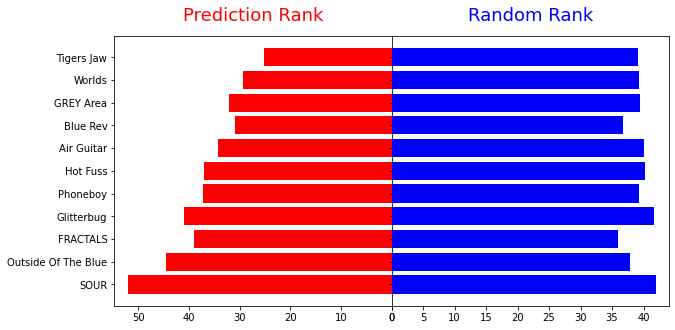

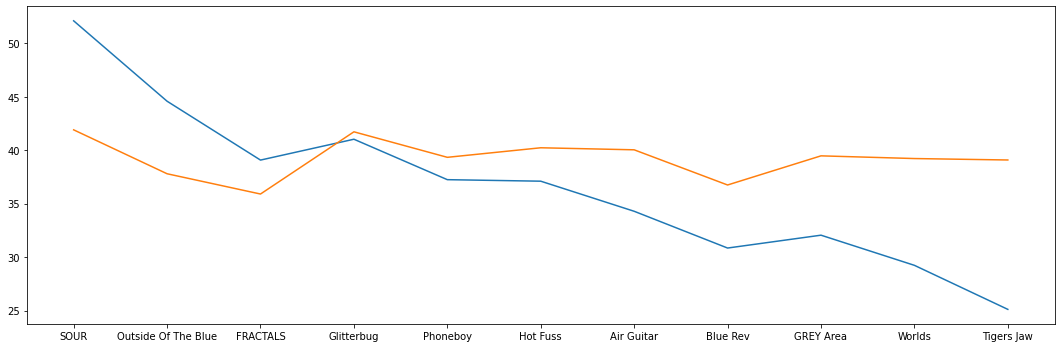

In [197]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
fig.tight_layout()

rank_df = rank_df.sort_values(by="algorithm_success", ascending=True)

axes[0].barh(rank_df.index, rank_df["prediction_rank"], align='center', color='r', zorder=10)
axes[0].set_title("Prediction Rank", fontsize=18, pad=15, color='r')
axes[1].barh(rank_df.index, rank_df["random_rank"], align='center', color='b', zorder=10)
axes[1].set_title("Random Rank", fontsize=18, pad=15, color='b')
axes[0].invert_xaxis() 
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

rank_df = rank_df.drop("algorithm_success", axis=1)
#rank_df.plot()

fig, axes = plt.subplots(figsize=(15,5))
fig.tight_layout()

line1, = plt.plot(rank_df["prediction_rank"], label="line1")
line2, = plt.plot(rank_df["random_rank"], label="line2")

rank_df

Lower values mean more accuracy. The difference refers to how much better or worse our algorithm was than random.

# Student's t-Test

In this statistical test, we calculate the means of two paired samples and determine if the means of the sample are statistically different. Here, we are using a student t-test to see if our model is better at predicting popularity than randomly guessing popularity.

In [198]:
from scipy.stats import ttest_ind
pred = prediction_rank
actual = random_rank
stat, p = ttest_ind(pred, actual)
print('stat=%.3f, p=%.3f' % (stat, p))

stat=-1.111, p=0.280


#Conclusion 

 

After comparing our model’s popularity predictions against random guessing using a student t-test, we concluded that while our predictions were better than chance, the p-value was not low enough to reject the null hypothesis. Therefore, we were unable to prove that our predictions were statistically significant. 

 

We were able to analyze some trends, such as determining that acousticness was a significant indicator that the model will rank that track as less popular. One reason our results may not be statistically significant may be because of the general difficulty in predicting song popularity due to random factors. People’s music tastes very greatly from person to person, and this variation was not present in our model.  

 

There are also greater factors outside of the listed API features that determine whether a song becomes popular, such as a song being played in a TV show or movie, or being played on the radio, which would expose the public to the song and generate more views and popularity. Overall, while our algorithm was more volatile than guessing randomly, the API features we used were not sufficient enough to predict a song’s popularity on their own. With these factors taken into account, it may be possible to create better predictions in the future by accounting for a track’s artist recognition, the tracks prevalence in popular culture, and the variation in people’s taste in music. 